# Notes
---
*   Output are already saved under folder `/output`
*   Notebook developed in Google Colab
*   The following [RNA draw library](https://github.com/DasLab/draw_rna) was used to depict the RNA secondary structure

# Libraries
---

In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import operator as op
from functools import reduce

*if your are not using Google Colab, ignore/remove the block below or else modify it to match your Google Drive paths*

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir("drive/My Drive/Colab Notebooks/Structural/Exercise1")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# RNA folding

---

*RNA folding*


### Initialization

In [3]:
rna = 'AAUACUCCGUUGCAGCAU'
length = len(rna)

def initMatrices():
    '''
    Initializes and returns W and V matrices
    '''

    x = np.zeros((length, length))
    y = np.zeros((length, length))
    for i in range(length):
        for j in range(length):
            if j - i < 5:
                x[i][j] = np.inf
                y[i][j] = np.inf
            else:
                x[i][j] = np.nan
                y[i][j] = np.nan
    return x, y
    

W, V = initMatrices()

### Energy of structures

In [4]:
def s(i,j):
    '''
    Returns stem energy

    @i, j: indexes of bases to check their bond
    '''
    if rna[i]+rna[j] in ["GC", "CG","AU", "UA"]:
        return -4
    if rna[i]+rna[j] in ["GU", "UG"]:
        return 0
    else:
        return 4

def h(j, i):
    '''
    Returns hairpin energy

    @i, j: indexes of bases
    '''
    return 2*(i-j+5)

### Computing secondary structure
<br>
$W(i, j)=\min \left\{\begin{array}{l}W(i-1, j), \\ W(i, j+1), \\ V(i, j), \quad(i, j) \text { defines structural element, } \\ \min _{k}\{W(i, k)+W(k-1, j): j+1<k<i\},\end{array}\right.$
<br><br>  

$V(i, j)=\min \left\{\begin{array}{ll}s(i, j)+h(i-1, j+1) & \text { hairpin: unmatched } r_{j+1}, \ldots, r_{i-1} \\ s(i, j)+W(i-1, j+1) & \text { match }(i, j), \text { then } r_{j+1}, \ldots, r_{i-1} \\ \end{array}\right.$

In [5]:
def get_min_k(j, i):
    '''
    Returns minimum value between the cells W[k,i], W(j, k - 1)

    @j, i:  
    '''

    minimum = float('inf')
    min_k = -1
    for k in range (j + 2, i):
        result = fillW(k, i) + fillW(j, k - 1)
        if result < minimum :
            minimum = result
            min_k = k
    return minimum

def fillW(j, i):
    '''
    Returns the energy of optimal structure for W(j, i)

    @i, j: indexes
    '''

    if i >= j + 5: 
        W[j][i] = min(
            fillW(j, i -1),
            fillW(j+1, i),
            fillV(j, i),
            get_min_k(j, i)
        )
    
    return W[j][i]


def fillV(j, i):
    '''
    Returns the energy of optimal structure for V(j, i) assuming (i, j) 
    is paired AND defines specific structural element

    @i, j: indexes
    '''

    V[j][i] = min(
        s(j,i) + h(j+1, i-1),
        s(j,i) + fillW(j+1, i-1)
    )

    return V[j][i]

fillW(0, length-1)
print("=============== W =================\n")
print(W)
print("\n=============== V =================\n")
print(V)

=============== W =================

[[inf inf inf inf inf 12. 12. 12. 12. 12. 10. 10. 10.  8.  4.  4.  0. -4.]
 [inf inf inf inf inf inf 20. 20. 18. 14. 10. 10. 10.  8.  4.  4.  0. -4.]
 [inf inf inf inf inf inf inf 20. 18. 14. 14. 12. 12.  8.  4.  4.  0.  0.]
 [inf inf inf inf inf inf inf inf 20. 14. 14. 12. 12.  8.  4.  4.  4.  0.]
 [inf inf inf inf inf inf inf inf inf 20. 20. 12. 12.  8.  4.  4.  4.  4.]
 [inf inf inf inf inf inf inf inf inf inf 20. 12. 12.  8.  8.  8.  8.  8.]
 [inf inf inf inf inf inf inf inf inf inf inf 12. 12. 12. 12. 12. 12. 12.]
 [inf inf inf inf inf inf inf inf inf inf inf inf 20. 20. 16. 12. 12. 12.]
 [inf inf inf inf inf inf inf inf inf inf inf inf inf 20. 16. 12. 12. 12.]
 [inf inf inf inf inf inf inf inf inf inf inf inf inf inf 16. 16. 14. 14.]
 [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf 20. 14. 14.]
 [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf 20. 18.]
 [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf i

### Backtrack Path

Starting again from the top right cell, we inspect the bottom - left neighbours   
to find whether the value was derived from one of them. If not then diagonal neighbour is checked. The 4th condition of W matrix never gets fullfilled for our particular data, so it's not into consideration, even though that's not a generalized move. Everytime, a condition is checked and matches the value of a position in W, the direction of path is saved into a list.

In [6]:
backtrack = []
i, j = 17, 0
while i -j >= 5:
    left = W[j][i-1] 
    bottom = W[j+1][i] 
    diagonal = V[j][i]  

    if W[j][i] == left:
        backtrack.append("left")
        i -= 1
    elif W[j][i] == bottom:
        backtrack.append("bottom")
        j += 1 
    elif W[j][i] == diagonal:
        if diagonal == s(j,i) + h(j+1, i-1):
            backtrack.append("hairpin")
        elif diagonal == s(j,i) + W[j+1, i-1]:
            backtrack.append("diagonal")
        j += 1 
        i -= 1
                
print(backtrack)

['bottom', 'diagonal', 'diagonal', 'left', 'bottom', 'diagonal', 'diagonal', 'left', 'hairpin']


### Results

From top-right cell of W matrix, we get the following backtrace path:  
['bottom', 'diagonal', 'diagonal', 'left', 'bottom', 'diagonal', 'diagonal', 'left', 'hairpin']

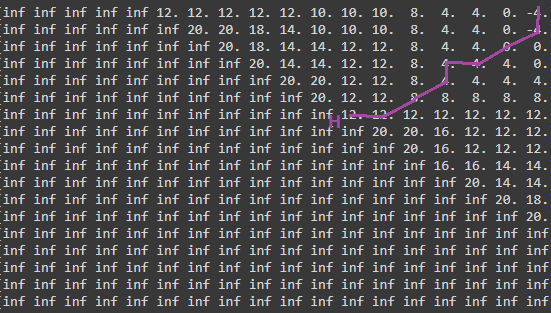

And it's notation: .((.((.......)).))

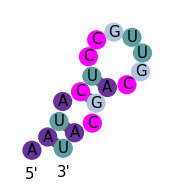